In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import Tracking_Py
import random

In [5]:
common_filepath = "F:/PhD_Franziska/Headon/memGFP/memGFP_RA/time_avg(window_size=5)/"
with h5py.File(common_filepath+"U_avg.h5", "r") as file:    
    U = file["matrix"][:]
with h5py.File(common_filepath+"V_avg.h5", "r") as file:    
    V = file["matrix"][:]
with h5py.File(common_filepath+"M_avg.h5", "r") as file:    
    U = file["matrix"][:]

with h5py.File("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_PIV.h5", "r") as file:  
    # xgrid and ygrid data the same from original PIV results. 
    xgrid = file["xgrid"][:]
    ygrid = file["ygrid"][:]

In [6]:
np.shape(U)

(48, 32, 32)

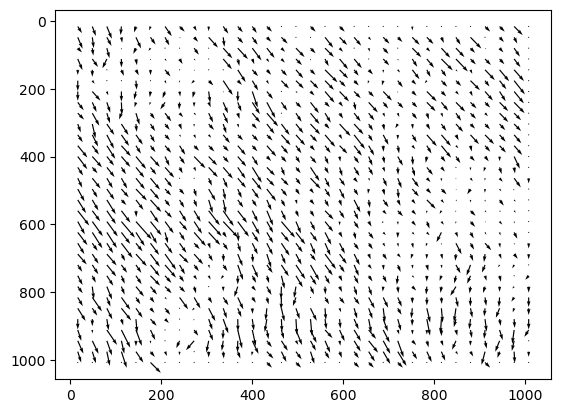

In [7]:
plt.quiver(xgrid[30], ygrid[30], V[30], -U[30])
plt.gca().invert_yaxis()

# Tracking with the whole image (2) -- Directly with the whole image. 

Has the advantage that the tracks are not in one limited region of aggregates/vector fields. Allow more complete tracking and therefore less error with tracks (especially long tracks)

In [6]:
x_test, y_test = Tracking_Py.pseudo_tracking_piv_grid_single_v2(U, V, [0, 38], [400], [800], 32)

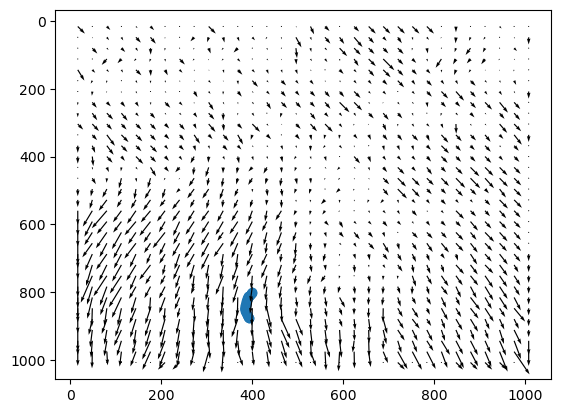

In [7]:
plt.scatter(x_test, y_test)
plt.quiver(xgrid[0], ygrid[0], V[20], -U[20])
plt.gca().invert_yaxis()

In [8]:
# Giving start points, time intervals.
# start_x_array = [[200], [200], [300], [300], [400], [400], 
#                  [100], [100], [200], [200], [300], [300],
#                 [400], [500], [400], [500], 
#                 [700], [700], [600], [800]]
# start_y_array = [[300], [500], [300], [500], [300], [500], 
#                  [800], [1000], [800], [1000], [800], [1000],
#                 [600], [850], [600], [850],
#                 [700], [900], [800], [800]]

start_x_array = [[random.randint(0,1000)] for i in range(200)]
start_y_array = [[random.randint(0,1000)] for i in range(200)]

t_array = [[0, 48]]*len(start_x_array)

whole_img_x, whole_img_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, t_array,
                                                                  start_x_array,
                                                                  start_y_array, 32)

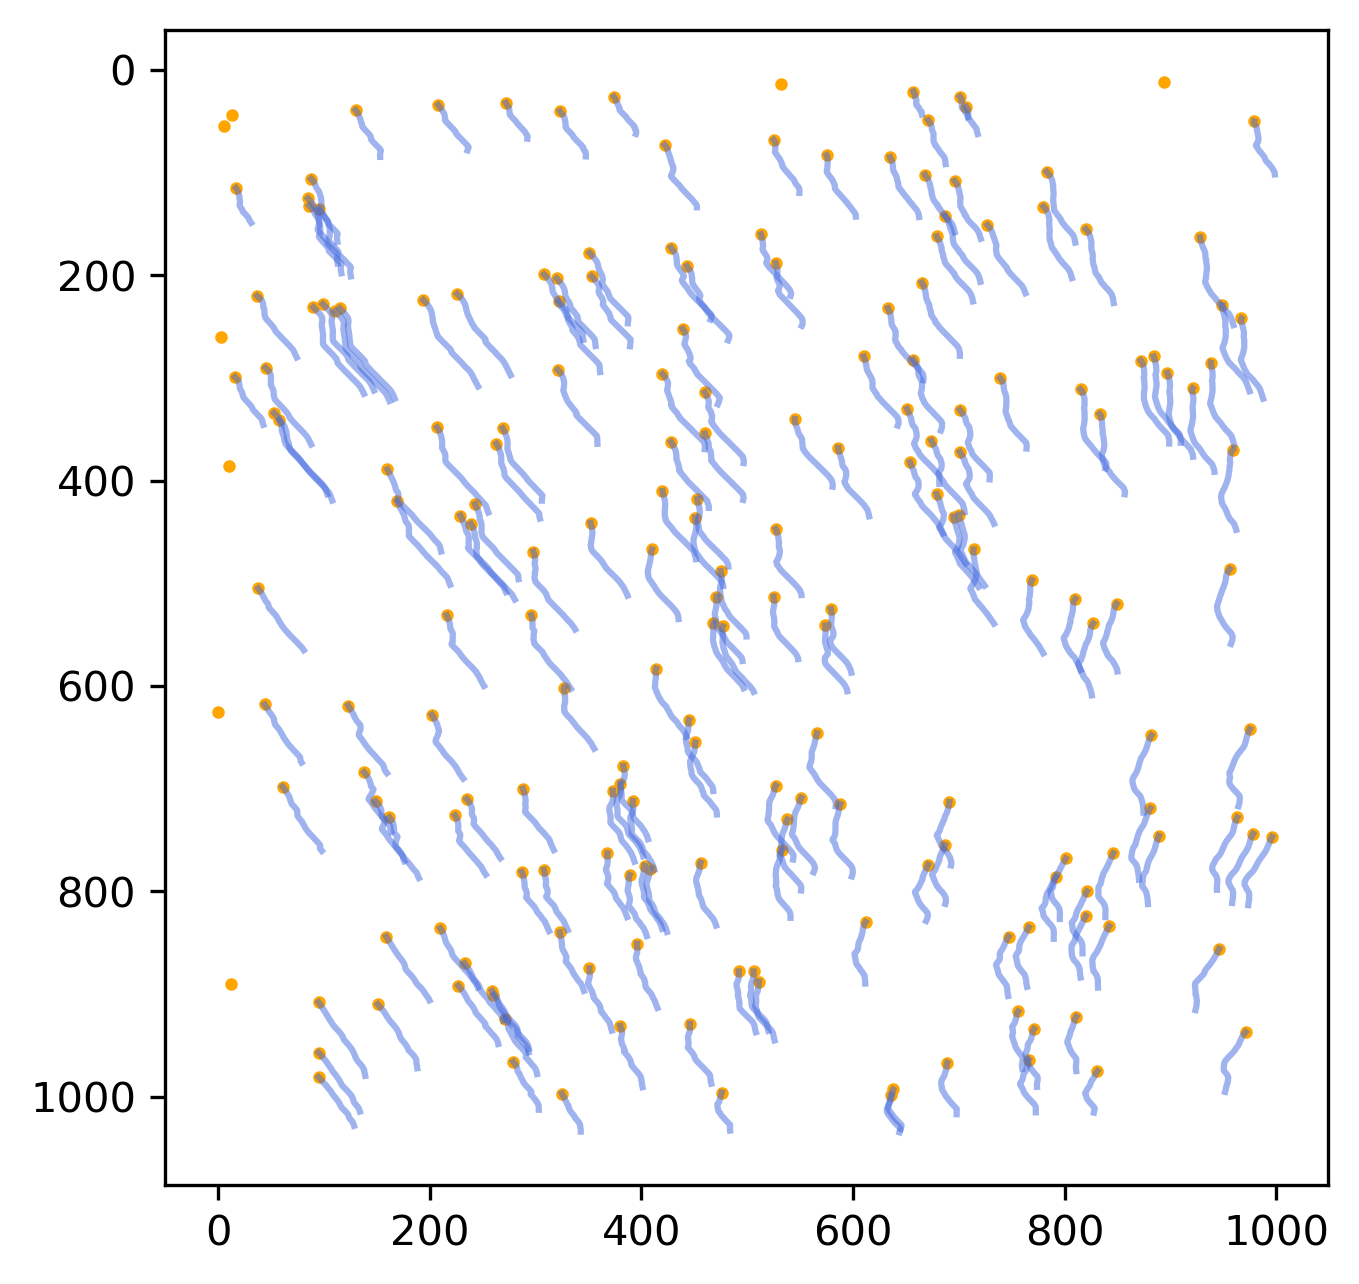

In [10]:
plt.figure(figsize=(5,5), dpi=300)
plt.quiver(xgrid[20], ygrid[20], V[20], -U[20])
#plt.quiver(agg1_xgrid, agg1_ygrid, agg1_V[100], -agg1_U[100])
for i in range(len(start_x_array)): 
    # plt.scatter(whole_img_x[i], whole_img_y[i], color = "royalblue", s=1, alpha=0.5)
    plt.scatter(start_x_array[i], start_y_array[i], color = "orange", s=4)
    plt.plot(whole_img_x[i], whole_img_y[i], color = "royalblue", alpha=0.5)
plt.gca().invert_yaxis()
plt.show()